In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Input,Activation
from tensorflow.keras.models import Model
import random as rn
import tensorflow as tf
import tensorflow.keras.backend as K
import datetime
from sklearn.preprocessing import OneHotEncoder
import tensorflow_hub as hub
import joblib
import pickle
from sklearn.metrics import f1_score,roc_auc_score,roc_auc_score,confusion_matrix,log_loss,roc_curve,auc
import sklearn

In [2]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/data/CS_2')
os.getcwd()

'/content/drive/MyDrive/data/CS_2'

## Final data pipeline for prediction

In [14]:
def final_prediction(X):
  """
  X takes file path for the csv,
  This function takes file path and returns the prediction whether the news is fake or not
  """
  # reading data
  csv=pd.read_csv(X)
  print('data loaded') 
  # repacing nan values with " "
  csv.fillna(' ')
  ##################################
  csv_text=csv['text']
  csv_title=csv['title']
  csv_author=csv['author']

  ########################    Preprocessing      ###############################

  # https://gist.github.com/sebleier/554280
  # refrence applied ai
  # we are removing the words from the stop words list: 'no', 'nor', 'not'
  stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
              'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
              'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
              'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
              'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
              'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
              'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
              'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
              'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
              's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
              've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
              "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
              "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
              'won', "won't", 'wouldn', "wouldn't"]

  def preprocessig_text(text):
    string=str(text)

    # removing url from text
    #http://urlregex.com/
    string=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ', string)
    #remove HTML from the Text column and save in the Text if present
    soup = BeautifulSoup(string, 'lxml')
    string = soup.get_text()    
    ################################################
    # decontracting text refrence applied ai
    string = re.sub(r"won't", "will not", string)
    string = re.sub(r"can\'t", "can not", string)
    string = re.sub(r"n\'t", " not", string)
    string = re.sub(r"\'re", " are", string)
    string = re.sub(r"\'s", " is", string)
    string = re.sub(r"\'d", " would", string)
    string = re.sub(r"\'ll", " will", string)
    string = re.sub(r"\'t", " not", string)
    string = re.sub(r"\'ve", " have", string)
    string = re.sub(r"\'m", " am", string)
    ###################################################

    string=re.sub('(@\w{1,})','',string) # removing usernames(@johndeapth)
    string=re.sub('pic.twitter.com/.+','',string) # removing image captions
    string=re.sub('\d',' ',string) # removing digits
    string=re.sub('\n',' ', string) # repacing new line character with one space
    string=re.sub('\t',' ', string) # replacing tab with space
    ##################################################################################################
    # removing some of the spacial charcters.
    string=re.sub('\.',' ',string) # removing period
    string=re.sub(',',' ', string) # removing comma
    string=re.sub('_',' ', string) # removing underscore
    string=re.sub('-',' ', string) # remving hyphen
    string=re.sub('[^A-aZ-z ]',' ', string) # removing all special charcters  expect space  and 
    #if diffent language wordcome it will also take care of it.
    string=re.sub('\[',' ', string) # removing square brackets
    string=re.sub('\]',' ', string) # 
    string=re.sub(' {2,}',' ', string) # replacing two or more spaces with one space
    string=string.strip()
    # removing stop words from text
    # https://gist.github.com/sebleier/554280
    string = ' '.join(e for e in string.split() if e.lower() not in stopwords)
    string=string.lower()
    string = re.sub(r'\b\w{1,2}\b'," ",string) #remove words <2
    string=re.sub(' {2,}','', string) # replacing two or more spaces with one space
    return string   
  

  ################### getting preprocessing done #####################################

  #Creating new columns for preprocessed text, title and author name.
  from tqdm import tqdm
  def get_preprocess(column):
      pre_pro_text=[]
      for i in tqdm(column):
          pre_text=''
          pre_text=preprocessig_text(i)
          pre_pro_text.append(pre_text)
      return pre_pro_text

  ######################################################################################

  pre_text_test=get_preprocess(csv_text)
  pre_title_test=get_preprocess(csv_title)
  pre_author_test=get_preprocess(csv_author)
  Print('Preprocessing done')
  # creating dictnory of all preprocessed list.
  # df_dic={"pre_text": pre_text_test,
  #         "pre_title":pre_title_test,
  #         "pre_author":pre_author_test}

  # # creating data frame
  # df=pd.DataFrame(df_dict,coloums=['pre_text','pre_title','Pre_author'])

  csv['pre_text']=pre_text_test
  csv['pre_title']=pre_title_test
  csv['pre_author']=pre_author_test

  ############### Merging all data into single data ##############################

  csv['merged']= csv['pre_text'] + csv['pre_title'] + csv['pre_author']

  ####################### Tokenization of data ##################################

  token_glove=joblib.load('Token_glove.pkl')
  encode_text_test=token_glove.texts_to_sequences(csv['merged'])

  ########################### padding of data ##################################

  max_length=int(1014)  # 95 precentile of the words in X_train.

  encode_text_test_paded=tf.keras.preprocessing.sequence.pad_sequences(encode_text_test, maxlen=max_length, padding='post')


  #################################### Loading best model for prediction   #################################


  def predict_test_thre(proba, threshould):
    predictions = []
    for i in proba:
        if i>=0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

  def Test_prediction(model,x_tr):
    y_predict_tr=model.predict(x_tr)
    pred=predict_test_thre(y_predict_tr, threshould=0.5)
    return pred
  print('Prediction is in process')
  # loading model
  lstm_cnn_model=tf.keras.models.load_model("best_model/CNN_b_model.h5")
  lstm_cnn_predictions=Test_prediction(lstm_cnn_model,encode_text_test_paded)
  csv['Prediction']=lstm_cnn_predictions
  sub_NN=csv[['id','Prediction']]
   
  pirnt('prediction done')

  return sub_NN
  

  

In [15]:
output=final_prediction('test.csv')

100%|██████████| 5200/5200 [00:02<00:00, 2250.82it/s]


In [16]:
output

,id,Prediction
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1


## Final data pipeline for validation

In [22]:
def final_validation(X,y):

  
  """
  X takes data and y takes class labels
  """

  csv=X
  csv_text=X['text']
  csv_title=X['title']
  csv_author=X['author']

  ########################    Preprocessing      ###############################

  # https://gist.github.com/sebleier/554280
  # refrence applied ai
  # we are removing the words from the stop words list: 'no', 'nor', 'not'
  stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
              'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
              'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
              'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
              'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
              'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
              'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
              'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
              'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
              's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
              've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
              "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
              "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
              'won', "won't", 'wouldn', "wouldn't"]

  def preprocessig_text(text):
    string=str(text)

    # removing url from text
    #http://urlregex.com/
    string=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ', string)
    #remove HTML from the Text column and save in the Text if present
    soup = BeautifulSoup(string, 'lxml')
    string = soup.get_text()    
    ################################################
    # decontracting text refrence applied ai
    string = re.sub(r"won't", "will not", string)
    string = re.sub(r"can\'t", "can not", string)
    string = re.sub(r"n\'t", " not", string)
    string = re.sub(r"\'re", " are", string)
    string = re.sub(r"\'s", " is", string)
    string = re.sub(r"\'d", " would", string)
    string = re.sub(r"\'ll", " will", string)
    string = re.sub(r"\'t", " not", string)
    string = re.sub(r"\'ve", " have", string)
    string = re.sub(r"\'m", " am", string)
    ###################################################

    string=re.sub('(@\w{1,})','',string) # removing usernames(@johndeapth)
    string=re.sub('pic.twitter.com/.+','',string) # removing image captions
    string=re.sub('\d',' ',string) # removing digits
    string=re.sub('\n',' ', string) # repacing new line character with one space
    string=re.sub('\t',' ', string) # replacing tab with space
    ##################################################################################################
    # removing some of the spacial charcters.
    string=re.sub('\.',' ',string) # removing period
    string=re.sub(',',' ', string) # removing comma
    string=re.sub('_',' ', string) # removing underscore
    string=re.sub('-',' ', string) # remving hyphen
    string=re.sub('[^A-aZ-z ]',' ', string) # removing all special charcters  expect space  and 
    #if diffent language wordcome it will also take care of it.
    string=re.sub('\[',' ', string) # removing square brackets
    string=re.sub('\]',' ', string) # 
    string=re.sub(' {2,}',' ', string) # replacing two or more spaces with one space
    string=string.strip()
    # removing stop words from text
    # https://gist.github.com/sebleier/554280
    string = ' '.join(e for e in string.split() if e.lower() not in stopwords)
    string=string.lower()
    string = re.sub(r'\b\w{1,2}\b'," ",string) #remove words <2
    string=re.sub(' {2,}','', string) # replacing two or more spaces with one space
    return string   
  

  ################### getting preprocessing done #####################################

  #Creating new columns for preprocessed text, title and author name.
  from tqdm import tqdm
  def get_preprocess(column):
      pre_pro_text=[]
      for i in tqdm(column):
          pre_text=''
          pre_text=preprocessig_text(i)
          pre_pro_text.append(pre_text)
      return pre_pro_text

  ######################################################################################

  pre_text_test=get_preprocess(csv_text)
  pre_title_test=get_preprocess(csv_title)
  pre_author_test=get_preprocess(csv_author)
  print('Preprocessing done')
  # creating dictnory of all preprocessed list.
  # df_dic={"pre_text": pre_text_test,
  #         "pre_title":pre_title_test,
  #         "pre_author":pre_author_test}

  # # creating data frame
  # df=pd.DataFrame(df_dict,coloums=['pre_text','pre_title','Pre_author'])

  csv['pre_text']=pre_text_test
  csv['pre_title']=pre_title_test
  csv['pre_author']=pre_author_test

  ############### Merging all data into single data ##############################

  csv['merged']= csv['pre_text'] + csv['pre_title'] + csv['pre_author']

  ####################### Tokenization of data ##################################

  token_glove=joblib.load('Token_glove.pkl')
  encode_text_test=token_glove.texts_to_sequences(csv['merged'])

  ########################### padding of data ##################################

  max_length=int(1014)  # 95 precentile of the words in X_train.

  encode_text_test_paded=tf.keras.preprocessing.sequence.pad_sequences(encode_text_test, maxlen=max_length, padding='post')


  #################################### Loading best model for prediction   #################################


  def predict_test_thre(proba, threshould):
    predictions = []
    for i in proba:
        if i>=0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

  def find_best_threshold(threshould, fpr, tpr):
      t = threshould[np.argmax(tpr*(1-fpr))]
      # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
      print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
      return t

  def predict_with_best_t(proba, threshould):
      predictions = []
      for i in proba:
          if i>=threshould:
              predictions.append(1)
          else:
              predictions.append(0)
      return predictions


  def Test_prediction(model,x_tr):
    y_predict_tr=model.predict(x_tr)
    pred=predict_test_thre(y_predict_tr, threshould=0.5)
    return pred
  print('Prediction is in process')
  # loading model
  lstm_cnn_model=tf.keras.models.load_model("best_model/CNN_b_model.h5")
  lstm_cnn_predictions=Test_prediction(lstm_cnn_model,encode_text_test_paded)
  csv['Prediction']=lstm_cnn_predictions

  fpr_tr,tpr_tr,thresold_tr=roc_curve(y,lstm_cnn_predictions)



  plt.figure(1)
  plt.figure(figsize=(7,4))
  #     plt.subplot(3,1,1)

  plt.plot(fpr_tr, tpr_tr, label="train AUC ="+str(auc(fpr_tr, tpr_tr)))

  plt.legend()
  plt.xlabel("fpr")
  plt.ylabel("tpr")
  plt.title("ROC_CURVE")
  plt.grid(True)
  plt.show()

  train_best_threshold=find_best_threshold(thresold_tr,fpr_tr,tpr_tr)

  prediction_tr=predict_with_best_t(lstm_cnn_predictions,train_best_threshold)


  plt.figure(2)
  plt.figure(figsize=(5,5))

  plt.subplot(2,1,1)
  conf_mat = pd.DataFrame(confusion_matrix(y, lstm_cnn_predictions))

  sns.heatmap(conf_mat, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'])
  plt.title('confusion matrix of test data')
  plt.xlabel('Actual')
  plt.ylabel('predicted')
  plt.show()




  print('AUC     =',auc(fpr_tr, tpr_tr))
  print('-'*110)
  print('logloss =',sklearn.metrics.log_loss(y,lstm_cnn_predictions))

  print('-'*110)
  print('F1     =',sklearn.metrics.f1_score(y,lstm_cnn_predictions))
  print('-'*110)
  print('Accuracy =',sklearn.metrics.accuracy_score(y,lstm_cnn_predictions))



In [20]:
x_test=pd.read_csv('X_cv_splitted.csv')
y=x_test['label']

100%|██████████| 6020/6020 [00:02<00:00, 2568.40it/s]


Preprocessing done
Prediction is in process


<Figure size 432x288 with 0 Axes>

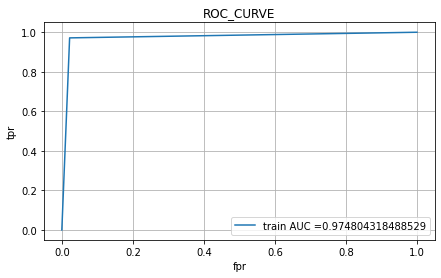

the maximum value of tpr*(1-fpr) 0.9502327935222673 for threshold 1


<Figure size 432x288 with 0 Axes>

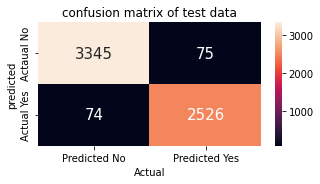

AUC     = 0.974804318488529
--------------------------------------------------------------------------------------------------------------
logloss = 0.8548733642274023
--------------------------------------------------------------------------------------------------------------
F1     = 0.9713516631417035
--------------------------------------------------------------------------------------------------------------
Accuracy = 0.975249169435216


In [23]:
final_validation(x_test,y)